In [ ]:
!pip install transformers datasets pandas scikit-learn

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    # @멘션 제거
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    # 특수문자, 숫자 제거
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # 다중 공백을 단일 공백으로 변경
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ===============================
# 1. 데이터 불러오기 및 기본 전처리
# ===============================
file_path = "/content/drive/MyDrive/tweet_emotions.csv"
df = pd.read_csv(file_path)

# tweet_id 열 제거
df = df.drop(columns=["tweet_id"], axis=1)

# 텍스트 전처리 적용
df["content"] = df["content"].apply(preprocess_text)

# ===============================
# 2. 감정 그룹(7가지) 통합 및 라벨 인코딩 (joy, love, sadness, anger, anxiety, surprise, neutral)
# ===============================
emotion_map_7 = {
    'happiness': 'joy',
    'fun': 'joy',
    'enthusiasm': 'joy',
    'love': 'love',
    'relief': 'love',
    'sadness': 'sadness',
    'empty': 'sadness',
    'anger': 'anger',
    'hate': 'anger',
    'worry': 'anxiety',
    'boredom': 'anxiety',
    'surprise': 'surprise',
    'neutral': 'neutral'
}

# 새로운 감정 그룹 열 생성
df['emotion_group'] = df['sentiment'].map(emotion_map_7)

# 라벨 인코딩 (숫자 레이블로 변환)
group7_encoder = LabelEncoder()
df['label'] = group7_encoder.fit_transform(df['emotion_group'])

# 클래스 확인
print("통합된 감정 클래스:", list(group7_encoder.classes_))

# ===============================
# 3. 정제된 데이터 저장
# ===============================
cleaned_file_path = "/content/sample_data/cleaned_tweet_emotions.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"전처리된 데이터가 {cleaned_file_path}에 저장되었습니다.")

통합된 감정 클래스: ['anger', 'anxiety', 'joy', 'love', 'neutral', 'sadness', 'surprise']
전처리된 데이터가 /content/sample_data/cleaned_tweet_emotions.csv에 저장되었습니다.


In [25]:
import pandas as pd

# 데이터 로드 (예시)
file_path = '/content/sample_data/cleaned_tweet_emotions.csv'  # 코랩 환경에 맞게 경로 수정
df = pd.read_csv(file_path)

# 결측값 제거
df = df.dropna(subset=["content"])  # NaN 제거

# 중복 데이터 제거
df = df.drop_duplicates(subset=["content"])  # 중복된 텍스트 제거

# 텍스트 정제: 모든 텍스트를 소문자로 변환
df["content"] = df["content"].str.lower()

# 텍스트 정제: 특수문자 제거
import re
df["content"] = df["content"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))

# 데이터 확인
print(df.head())
print(df.info())

    sentiment                                            content  \
0       empty  i know i was listenin to bad habit earlier and...   
1     sadness  layin n bed with a headache ughhhhwaitin on yo...   
2     sadness                      funeral ceremonygloomy friday   
3  enthusiasm                wants to hang out with friends soon   
4     neutral  we want to trade with someone who has houston ...   

  emotion_group  label  
0       sadness      5  
1       sadness      5  
2       sadness      5  
3           joy      2  
4       neutral      4  
<class 'pandas.core.frame.DataFrame'>
Index: 39041 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      39041 non-null  object
 1   content        39041 non-null  object
 2   emotion_group  39041 non-null  object
 3   label          39041 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB
None


In [28]:
from sklearn.preprocessing import LabelEncoder

# 감정 그룹 기준으로 라벨 인코딩(BERT는 숫자 입력을 사용하므로 감정 라벨(emotion_group)을 숫자로 변환해야 합니다.)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["emotion_group"]) # emotion_group 컬럼을 숫자로 변환
print(label_encoder.classes_)  # 라벨 순서 확인

# 라벨 숫자 추가되었는지 확인..
print(df[["emotion_group", "label"]].head())

['anger' 'anxiety' 'joy' 'love' 'neutral' 'sadness' 'surprise']
  emotion_group  label
0       sadness      5
1       sadness      5
2       sadness      5
3           joy      2
4       neutral      4


클래스 분포:
label
1    8510
4    8316
2    7575
5    5888
3    5174
6    2152
0    1426
Name: count, dtype: int64

클래스 비율 (%):
label
1    21.797597
4    21.300684
2    19.402679
5    15.081581
3    13.252734
6     5.512154
0     3.652570
Name: proportion, dtype: float64


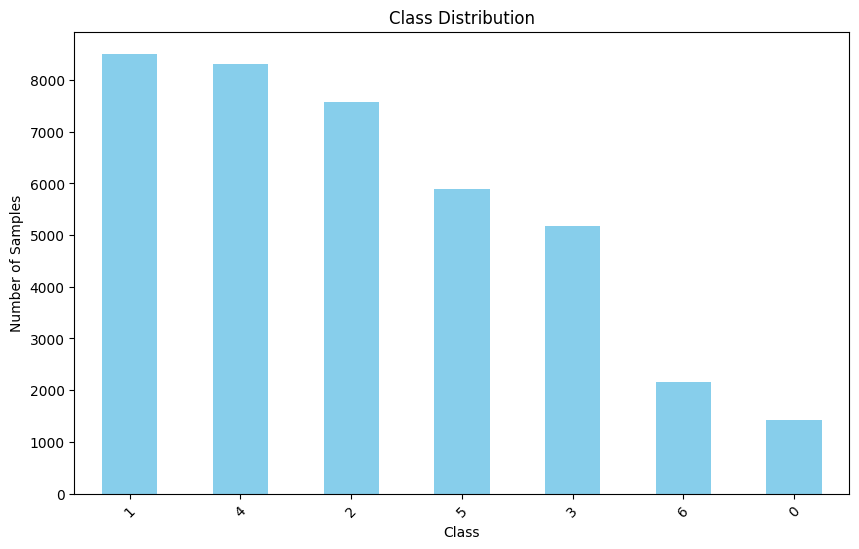

In [29]:
# 클래스 분포 확인
class_distribution = df["label"].value_counts()

# 비율 계산
class_percentage = df["label"].value_counts(normalize=True) * 100

# 분포 출력
print("클래스 분포:")
print(class_distribution)
print("\n클래스 비율 (%):")
print(class_percentage)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [32]:
import torch
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight="balanced", classes=df["label"].unique(), y=df["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float)

# 손실 함수에 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [33]:
import pandas as pd
import torch
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# 데이터 정제
df = df[df["content"].apply(lambda x: isinstance(x, str))]  # 문자열만 남기기

# 라벨 인코딩
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])  # label을 정수로 변환

# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=df["label"].unique(),
    y=df["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # PyTorch Tensor 변환

# 학습 데이터와 검증 데이터 분리
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["content"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 토크나이징 함수 정의
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

# 학습 데이터와 검증 데이터 토크나이징
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# PyTorch Dataset 정의
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Dataset 생성
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 손실 함수에 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 결과 확인
print(f"Class Weights: {class_weights}")
print(f"Train Dataset Size: {len(train_dataset)}")

Class Weights: tensor([0.9472, 0.7363, 0.6707, 0.6554, 2.5917, 1.0779, 3.9111])
Train Dataset Size: 31232


In [34]:
#---------------------------------(확인 절차)----------------------------------------
# 각 문장의 길이 계산 -> max_length 설정에 영향을 줌. -> 어린이 동화 정도면 사실상 64토큰(30~40 단어 정도로 충분함.) -> pad를 줄이자.
text_lengths = [len(tokenizer(text)["input_ids"]) for text in df["content"]]

print("최대 길이:", max(text_lengths))
print("평균 길이:", sum(text_lengths) / len(text_lengths))
print("최소 길이:", min(text_lengths))

최대 길이: 55
평균 길이: 16.940882661817064
최소 길이: 3


In [35]:
len(train_texts), len(train_labels), len(val_texts), len(val_labels)

(31232, 31232, 7809, 7809)

In [36]:
print(train_encodings["input_ids"].shape)
print(val_encodings["input_ids"].shape)

torch.Size([31232, 64])
torch.Size([7809, 64])


In [37]:
#데이터 셋 생성
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # 리스트 → 텐서 변환

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]  # dtype=torch.long 적용됨
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

In [38]:
#-------------------------------------------------------------------
from collections import Counter

# Train과 Validation 데이터 분포 출력
print("Train label distribution:", Counter(train_labels))
print("Validation label distribution:", Counter(val_labels))

Train label distribution: Counter({1: 6823, 4: 6672, 2: 6033, 5: 4706, 3: 4142, 6: 1701, 0: 1155})
Validation label distribution: Counter({1: 1687, 4: 1644, 2: 1542, 5: 1182, 3: 1032, 6: 451, 0: 271})


In [39]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

class CustomDistilBERTModel(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # device 수정
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)  # 가중치 적용

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # 모델 호출 시 전달되는 불필요한 인자를 처리하지 않도록 수정
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


# 라벨 개수 설정
num_labels = len(label_encoder.classes_)

# Custom DistilBERT 모델 로드
model = CustomDistilBERTModel.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    class_weights=class_weights  # 가중치 전달
)

# 특정 레이어 동결 (프리트레인된 부분은 학습하지 않음)
for param in model.distilbert.parameters():
    param.requires_grad = False  # DistilBERT 본체 동결

for param in model.classifier.parameters():
    param.requires_grad = True  # 분류기 부분만 학습


# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # 에포크마다 평가
    save_strategy="epoch",        # 에포크마다 저장
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # 배치 크기 16
    num_train_epochs=10,            # 10 에포크
    load_best_model_at_end=True,    # 최고의 모델 저장
    save_total_limit=2,             # 체크포인트 제한
    logging_dir="./logs",
    report_to="wandb",  # W&B 활성화
    lr_scheduler_type="linear",  # 학습률 스케줄러 설정 (learning rate 감소)
    weight_decay=0.01,           # L2 정규화 (가중치 감쇠)
    warmup_steps=500,            # warmup steps 설정
)

# EarlyStoppingCallback을 추가하여 검증 손실이 개선되지 않으면 훈련을 멈추도록 설정
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback]  # EarlyStoppingCallback 추가
)

Some weights of CustomDistilBERTModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-39-1a081d89e4d2>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
#-----------------------------------------------------
print(f"Number of labels: {num_labels}")
print(len(train_dataset))  # 학습 데이터 크기 확인
print(len(val_dataset))    # 검증 데이터 크기 확인
#-------------------------------------------------------

Number of labels: 7
31232
7809


In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.649600,1.658171
2,1.589500,1.608233
3,1.577800,1.590450
4,1.552600,1.580357
5,1.545500,1.566725
6,1.546700,1.559491
7,1.528100,1.553827
8,1.525700,1.551585
9,1.517100,1.551375
10,1.526500,1.551112


TrainOutput(global_step=19520, training_loss=1.563172234081831, metrics={'train_runtime': 762.5955, 'train_samples_per_second': 409.549, 'train_steps_per_second': 25.597, 'total_flos': 5171988377763840.0, 'train_loss': 1.563172234081831, 'epoch': 10.0})

In [83]:
df_external_test = pd.read_csv("/content/test_data.csv")

In [84]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer

# 1. 토크나이저 준비
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# 2. 전처리
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_external_test["content"] = df_external_test["content"].apply(preprocess_text)

# 3. 토크나이징
test_encodings = tokenizer(
    df_external_test["content"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# 4. EmotionDataset 클래스 활용
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# 라벨 추출
test_labels = df_external_test["label"].tolist()
test_dataset = EmotionDataset(test_encodings, test_labels)

# 5. 모델 평가 (정확도 계산)
model.eval()
predictions = []
true_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in torch.utils.data.DataLoader(test_dataset, batch_size=16):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 6. 정확도 출력
accuracy = accuracy_score(true_labels, predictions)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# 추가: F1-score 등 상세 성능 보고서
print("\n📊 Classification Report:")
print(classification_report(true_labels, predictions))

✅ Test Accuracy: 0.9246

📊 Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.92      0.96      5000
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.92      5000
   macro avg       0.17      0.15      0.16      5000
weighted avg       1.00      0.92      0.96      5000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# 모델 저장 경로를 지정
save_directory = '/content/saved_model'

# 모델 저장
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("모델이 저장되었습니다:", save_directory)

모델이 저장되었습니다: /content/saved_model


In [44]:
import shutil

# 모델 폴더를 압축
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

print("압축 완료: /content/saved_model.zip")

압축 완료: /content/saved_model.zip


In [ ]:
from google.colab import files

# 압축된 파일 다운로드
files.download('/content/saved_model.zip')